# **Shopping**

- Inter-arrival time ~ Exponential(2)
- Customer demand ~ Uniform[1,5] liters
- Milk fetch time = 1 minute/liter
- Number of Cashiers = 2
- Bill payment time = 2 minutes/customer
---

In [59]:
import simpy
import random

In [60]:
random.seed(42)

In [61]:
env = simpy.Environment()

In [62]:
cashiers = simpy.Resource(env=env, capacity=2)

In [63]:
def customer(env, name, cashiers):
    milk_required = random.randint(1,5)
    print(f"{name}: Arrives at time: {env.now : .2f}, and requires {milk_required}L milk.")
    yield env.timeout(milk_required)
    print(f"{name}: finishes retreiving the milk at time: {env.now : .2f}.")
    with cashiers.request() as cashier_req:
        yield cashier_req
        print(f'{name}: gets a cashier at time: {env.now : .2f}.')
        yield env.timeout(2)
        print(f'{name}: leaves at time: {env.now : .2f}')

In [64]:
def customer_generator(env, cashiers):
    cust_number = 1
    while True:
        random_inter_arrival_time = random.expovariate(lambd = 2)
        yield env.timeout(random_inter_arrival_time)
        env.process(customer(env=env, name=f"customer {cust_number}", cashiers=cashiers))
        cust_number += 1

In [65]:
env.process(customer_generator(env=env, cashiers=cashiers))
env.run(until=10) # 10 mins

customer 1: Arrives at time:  0.51, and requires 3L milk.
customer 2: Arrives at time:  0.52, and requires 2L milk.
customer 3: Arrives at time:  0.66, and requires 5L milk.
customer 4: Arrives at time:  1.33, and requires 4L milk.
customer 5: Arrives at time:  1.38, and requires 1L milk.
customer 6: Arrives at time:  1.39, and requires 5L milk.
customer 7: Arrives at time:  1.51, and requires 5L milk.
customer 8: Arrives at time:  1.98, and requires 5L milk.
customer 9: Arrives at time:  2.09, and requires 4L milk.
customer 10: Arrives at time:  2.36, and requires 1L milk.
customer 5: finishes retreiving the milk at time:  2.38.
customer 5: gets a cashier at time:  2.38.
customer 2: finishes retreiving the milk at time:  2.52.
customer 2: gets a cashier at time:  2.52.
customer 11: Arrives at time:  2.80, and requires 2L milk.
customer 10: finishes retreiving the milk at time:  3.36.
customer 1: finishes retreiving the milk at time:  3.51.
customer 12: Arrives at time:  3.51, and requ

---
# Containers

In [66]:
env = simpy.Environment()

In [67]:
cashiers = simpy.Resource(env=env, capacity=2)

In [68]:
def customer(env, name, cashiers, fridge):
    milk_required = random.randint(1,5)
    print(f"{name}: Arrives at time: {env.now : .2f}, and requires {milk_required}L milk.")
    yield env.timeout(milk_required)

    yield fridge.get(milk_required)

    print(f"{name}: finishes retreiving the milk at time: {env.now : .2f}. Fridge has {fridge.level}L milk remaining.")
    with cashiers.request() as cashier_req:
        yield cashier_req
        print(f'{name}: gets a cashier at time: {env.now : .2f}.')
        yield env.timeout(2)
        print(f'{name}: leaves at time: {env.now : .2f}')

In [69]:
def customer_generator(env, cashiers, fridge):
    cust_number = 1
    while True:
        random_inter_arrival_time = random.expovariate(lambd = 2)
        yield env.timeout(random_inter_arrival_time)
        env.process(customer(env=env, name=f"customer {cust_number}", cashiers=cashiers, fridge=fridge))
        cust_number += 1

In [70]:
fridge = simpy.Container(env=env, capacity=50, init=15)

In [71]:
env.process(customer_generator(env=env, cashiers=cashiers, fridge=fridge))
env.run(until=10) # 10 mins

customer 1: Arrives at time:  0.97, and requires 4L milk.
customer 2: Arrives at time:  1.97, and requires 3L milk.
customer 3: Arrives at time:  2.14, and requires 3L milk.
customer 4: Arrives at time:  2.22, and requires 3L milk.
customer 5: Arrives at time:  2.34, and requires 1L milk.
customer 6: Arrives at time:  2.95, and requires 2L milk.
customer 5: finishes retreiving the milk at time:  3.34. Fridge has 14L milk remaining.
customer 5: gets a cashier at time:  3.34.
customer 7: Arrives at time:  3.42, and requires 2L milk.
customer 8: Arrives at time:  3.80, and requires 4L milk.
customer 9: Arrives at time:  3.89, and requires 5L milk.
customer 10: Arrives at time:  4.05, and requires 3L milk.
customer 11: Arrives at time:  4.17, and requires 1L milk.
customer 6: finishes retreiving the milk at time:  4.95. Fridge has 12L milk remaining.
customer 6: gets a cashier at time:  4.95.
customer 1: finishes retreiving the milk at time:  4.97. Fridge has 8L milk remaining.
customer 2:

---
# Modeling the Fridge as a Resource

In [72]:
env = simpy.Environment()

cashiers = simpy.Resource(env=env, capacity=2)

def customer(env, name, cashiers, fridge):
    milk_required = random.randint(1, 5)
    print(f"{name}: Arrives at time: {env.now:.2f}, and requires {milk_required}L milk.")
    
    # Request fridge access
    with fridge['resource'].request() as fridge_req:
        yield fridge_req  # Wait for fridge access
    
        yield env.timeout(milk_required)  # Simulate time to retrieve milk

        yield fridge['milk_container'].get(milk_required)  # Get milk from fridge

    print(f"{name}: finishes retrieving the milk at time: {env.now:.2f}. Fridge has {fridge['milk_container'].level}L milk remaining.")
    
    # Request cashier access
    with cashiers.request() as cashier_req:
        yield cashier_req  # Wait for a cashier
        print(f'{name}: gets a cashier at time: {env.now:.2f}.')
        yield env.timeout(2)  # Simulate checkout time
        print(f'{name}: leaves at time: {env.now:.2f}.')

def customer_generator(env, cashiers, fridge):
    cust_number = 1
    while True:
        random_inter_arrival_time = random.expovariate(lambd=2)
        yield env.timeout(random_inter_arrival_time)  # Time between customer arrivals
        env.process(customer(env=env, name=f"customer {cust_number}", cashiers=cashiers, fridge=fridge))
        cust_number += 1

# Fridge resources: 1 fridge, and a container starting with 15L of milk (max 50L)
fridge = {'resource': simpy.Resource(env=env, capacity=1), 'milk_container': simpy.Container(env=env, capacity=50, init=15)}

# Start the customer generator process
env.process(customer_generator(env=env, cashiers=cashiers, fridge=fridge))

# Run the simulation for 10 simulated minutes
env.run(until=10)

customer 1: Arrives at time: 0.36, and requires 1L milk.
customer 2: Arrives at time: 0.40, and requires 2L milk.
customer 1: finishes retrieving the milk at time: 1.36. Fridge has 14L milk remaining.
customer 1: gets a cashier at time: 1.36.
customer 3: Arrives at time: 1.39, and requires 4L milk.
customer 4: Arrives at time: 1.88, and requires 4L milk.
customer 5: Arrives at time: 2.34, and requires 4L milk.
customer 6: Arrives at time: 2.58, and requires 5L milk.
customer 7: Arrives at time: 2.96, and requires 1L milk.
customer 1: leaves at time: 3.36.
customer 2: finishes retrieving the milk at time: 3.36. Fridge has 12L milk remaining.
customer 2: gets a cashier at time: 3.36.
customer 8: Arrives at time: 3.94, and requires 1L milk.
customer 9: Arrives at time: 4.51, and requires 5L milk.
customer 10: Arrives at time: 5.08, and requires 3L milk.
customer 2: leaves at time: 5.36.
customer 11: Arrives at time: 5.78, and requires 4L milk.
customer 12: Arrives at time: 5.84, and requi

---
# Yielding a Pricess

In [73]:
env = simpy.Environment()

cashiers = simpy.Resource(env=env, capacity=2)

def customer(env, name, cashiers, fridge):
    milk_required = random.randint(1, 5)
    print(f"{name}: Arrives at time: {env.now:.2f}, and requires {milk_required}L milk.")
    
    # Request fridge access
    with fridge['resource'].request() as fridge_req:
        yield fridge_req  # Wait for fridge access
    
        yield env.timeout(milk_required)  # Simulate time to retrieve milk

        yield fridge['milk_container'].get(milk_required)  # Get milk from fridge

    print(f"{name}: finishes retrieving the milk at time: {env.now:.2f}. Fridge has {fridge['milk_container'].level}L milk remaining.")
    
    # Request cashier access
    with cashiers.request() as cashier_req:
        yield cashier_req  # Wait for a cashier
        print(f'{name}: gets a cashier at time: {env.now:.2f}.')
        yield env.timeout(2)  # Simulate checkout time
        print(f'{name}: leaves at time: {env.now:.2f}.')

def customer_generator(env, cashiers, fridge):
    cust_number = 1
    while True:
        random_inter_arrival_time = random.expovariate(lambd=2)
        yield env.timeout(random_inter_arrival_time)  # Time between customer arrivals
        env.process(customer(env=env, name=f"customer {cust_number}", cashiers=cashiers, fridge=fridge))
        cust_number += 1

def fridge_control_process(env, fridge):
    while True:
        if fridge['milk_container'].level < 5:
            yield env.process(fridge_refill_process(env, fridge))

        yield env.timeout(random.uniform(10,20))

def fridge_refill_process(env, fridge):
    print(f"Fridge refill pricess called at time {env.now: .2f}.")
    yield env.timeout(2) # 2 minutes
    to_refill = 15 - fridge['milk_container'].level # 15L of milk required
    print(f"Fridge has {fridge['milk_container'].level}L milk. Fridge filled with {to_refill}L milk.")
    yield fridge['milk_container'].put(to_refill)

# Fridge resources: 1 fridge, and a container starting with 15L of milk (max 50L)
fridge = {'resource': simpy.Resource(env=env, capacity=1), 'milk_container': simpy.Container(env=env, capacity=50, init=15)}

# Start the customer generator process
env.process(customer_generator(env=env, cashiers=cashiers, fridge=fridge))

env.process(fridge_control_process(env=env, fridge=fridge))

# Run the simulation for 60 simulated minutes
env.run(until=60)

customer 1: Arrives at time: 0.92, and requires 3L milk.
customer 2: Arrives at time: 1.03, and requires 5L milk.
customer 3: Arrives at time: 1.75, and requires 5L milk.
customer 4: Arrives at time: 3.29, and requires 5L milk.
customer 1: finishes retrieving the milk at time: 3.92. Fridge has 12L milk remaining.
customer 1: gets a cashier at time: 3.92.
customer 5: Arrives at time: 4.54, and requires 1L milk.
customer 6: Arrives at time: 4.73, and requires 3L milk.
customer 7: Arrives at time: 4.79, and requires 3L milk.
customer 8: Arrives at time: 5.85, and requires 2L milk.
customer 1: leaves at time: 5.92.
customer 9: Arrives at time: 5.99, and requires 1L milk.
customer 10: Arrives at time: 7.04, and requires 4L milk.
customer 11: Arrives at time: 7.08, and requires 5L milk.
customer 12: Arrives at time: 7.93, and requires 2L milk.
customer 13: Arrives at time: 8.65, and requires 5L milk.
customer 2: finishes retrieving the milk at time: 8.92. Fridge has 7L milk remaining.
custom

---
# Condition Event

In [74]:
env = simpy.Environment()

cashiers = simpy.Resource(env=env, capacity=2)

def customer(env, name, cashiers, fridge):
    milk_required = random.randint(1, 5)
    print(f"{name}: Arrives at time: {env.now:.2f}, and requires {milk_required}L milk.")
    
    # Request fridge access
    with fridge['resource'].request() as fridge_req:
        res = yield fridge_req | env.timeout(10) # Wait for fridge access for 10 mins
        if fridge_req in res:
            yield env.timeout(milk_required)  # Simulate time to retrieve milk

            yield fridge['milk_container'].get(milk_required)  # Get milk from fridge
        else:
            print(f"{name}: left without buying milk at time: {env.now:.2f}.")
            return

    print(f"{name}: finishes retrieving the milk at time: {env.now:.2f}. Fridge has {fridge['milk_container'].level}L milk remaining.")
    
    # Request cashier access
    with cashiers.request() as cashier_req:
        yield cashier_req  # Wait for a cashier
        print(f'{name}: gets a cashier at time: {env.now:.2f}.')
        yield env.timeout(2)  # Simulate checkout time
        print(f'{name}: leaves at time: {env.now:.2f}.')

def customer_generator(env, cashiers, fridge):
    cust_number = 1
    while True:
        random_inter_arrival_time = random.expovariate(lambd=0.5)
        yield env.timeout(random_inter_arrival_time)  # Time between customer arrivals
        env.process(customer(env=env, name=f"customer {cust_number}", cashiers=cashiers, fridge=fridge))
        cust_number += 1

def fridge_control_process(env, fridge):
    while True:
        if fridge['milk_container'].level < 5:
            yield env.process(fridge_refill_process(env, fridge))

        yield env.timeout(random.uniform(10,20))

def fridge_refill_process(env, fridge):
    print(f"Fridge refill pricess called at time {env.now: .2f}.")
    yield env.timeout(2) # 2 minutes
    to_refill = 15 - fridge['milk_container'].level # 15L of milk required
    print(f"Fridge has {fridge['milk_container'].level}L milk. Fridge filled with {to_refill}L milk.")
    yield fridge['milk_container'].put(to_refill)

# Fridge resources: 1 fridge, and a container starting with 15L of milk (max 50L)
fridge = {'resource': simpy.Resource(env=env, capacity=1), 'milk_container': simpy.Container(env=env, capacity=50, init=15)}

# Start the customer generator process
env.process(customer_generator(env=env, cashiers=cashiers, fridge=fridge))

env.process(fridge_control_process(env=env, fridge=fridge))

# Run the simulation for 60 simulated minutes
env.run(until=60)

customer 1: Arrives at time: 0.62, and requires 1L milk.
customer 2: Arrives at time: 0.85, and requires 2L milk.
customer 1: finishes retrieving the milk at time: 1.62. Fridge has 14L milk remaining.
customer 1: gets a cashier at time: 1.62.
customer 1: leaves at time: 3.62.
customer 2: finishes retrieving the milk at time: 3.62. Fridge has 12L milk remaining.
customer 2: gets a cashier at time: 3.62.
customer 3: Arrives at time: 4.76, and requires 4L milk.
customer 4: Arrives at time: 5.21, and requires 2L milk.
customer 2: leaves at time: 5.62.
customer 5: Arrives at time: 6.07, and requires 2L milk.
customer 6: Arrives at time: 6.57, and requires 3L milk.
customer 7: Arrives at time: 7.59, and requires 3L milk.
customer 3: finishes retrieving the milk at time: 8.76. Fridge has 8L milk remaining.
customer 3: gets a cashier at time: 8.76.
customer 3: leaves at time: 10.76.
customer 4: finishes retrieving the milk at time: 10.76. Fridge has 6L milk remaining.
customer 4: gets a cashie

---
# Business Case Study
## Number of Fridges vs Lost Customers

In [75]:
import simpy
import random
import numpy as np

In [76]:
SIM_TIME = 1 * 24 * 60 # 1 day

In [77]:
stats = {'customers_lost':0,
         'customers_lost_iter':[],
         'customers_lost_experiment':[]}

In [78]:
def customer(env, name, cashiers, fridges):
    milk_required = random.randint(1, 5)
    # print(f"{name}: Arrives at time: {env.now:.2f}, and requires {milk_required}L milk.")
    waiting_customers = [len(fridge['resource'].queue) for fridge in fridges]

    fridge_num = waiting_customers.index(min(waiting_customers))

    fridge = fridges[fridge_num]
    
    # Request fridge access
    with fridge['resource'].request() as fridge_req:
        res = yield fridge_req | env.timeout(10) # Wait for fridge access for 10 mins
        if fridge_req in res:
            yield env.timeout(milk_required)  # Simulate time to retrieve milk

            yield fridge['milk_container'].get(milk_required)  # Get milk from fridge
        else:
            # print(f"{name}: left without buying milk at time: {env.now:.2f}.")
            stats['customers_lost'] += 1
            return

    # print(f"{name}: finishes retrieving the milk at time: {env.now:.2f}. Fridge has {fridge['milk_container'].level}L milk remaining.")
    
    # Request cashier access
    with cashiers.request() as cashier_req:
        yield cashier_req  # Wait for a cashier
        # print(f'{name}: gets a cashier at time: {env.now:.2f}.')
        yield env.timeout(2)  # Simulate checkout time
        # print(f'{name}: leaves at time: {env.now:.2f}.')

def customer_generator(env, cashiers, fridges):
    cust_number = 1
    while True:
        random_inter_arrival_time = random.expovariate(lambd=0.5)
        yield env.timeout(random_inter_arrival_time)  # Time between customer arrivals
        env.process(customer(env=env, name=f"customer {cust_number}", cashiers=cashiers, fridges=fridges))
        cust_number += 1

def fridge_control_process(env, fridge):
    while True:
        if fridge['milk_container'].level < 5:
            yield env.process(fridge_refill_process(env, fridge))

        yield env.timeout(random.uniform(10,20))

def fridge_refill_process(env, fridge):
    # print(f"Fridge refill pricess called at time {env.now: .2f}.")
    yield env.timeout(2) # 2 minutes
    to_refill = 15 - fridge['milk_container'].level # 15L of milk required
    # print(f"Fridge has {fridge['milk_container'].level}L milk. Fridge filled with {to_refill}L milk.")
    yield fridge['milk_container'].put(to_refill)



In [79]:
for num_fridges in range(1,11):
    for r in range(10):
        random.seed(r)

        env = simpy.Environment()

        cashiers = simpy.Resource(env=env, capacity=2)

        fridges = [{'resource': simpy.Resource(env=env, capacity=1), 'milk_container': simpy.Container(env=env, capacity=50, init=15)} for i in range(num_fridges)]

        # Start the customer generator process
        env.process(customer_generator(env=env, cashiers=cashiers, fridges=fridges))
        for fridge in fridges:
            env.process(fridge_control_process(env=env, fridge=fridge))

        # Run the simulation for 60 simulated minutes
        env.run(until=SIM_TIME)
        stats['customers_lost_iter'].append(stats['customers_lost'])
        stats['customers_lost'] = 0
    stats['customers_lost_experiment'].append(np.mean(stats['customers_lost_iter']))
    stats['customers_lost_iter'] = []

In [80]:
stats

{'customers_lost': 0,
 'customers_lost_iter': [],
 'customers_lost_experiment': [340.7,
  82.8,
  26.1,
  19.3,
  18.7,
  14.8,
  15.7,
  16.6,
  18.4,
  17.1]}

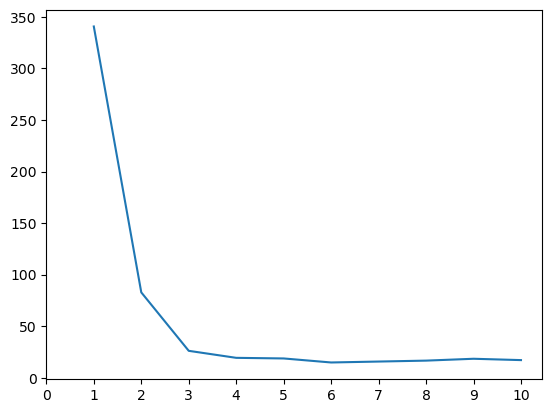

In [83]:
import matplotlib.pyplot as plt

plt.plot(range(1,11), stats['customers_lost_experiment']);
plt.xticks(range(11));